In [71]:
#Usual suspects
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Optional
import pickle
from functools import partial
import math
import time

# Add path to our library
import sys
sys.path.insert(1,'../muograph/')

# Import get_hits_from_csv from utils.py
from utils.utils import get_hits_from_csv
hits = get_hits_from_csv('../data/DataCu.csv')


# <center> Reconstruction full tutorial

This tutorial will demonstrate how to use the muograph reconstruction framework, which combines the 3 first tutorials:

 - **Tracking** (Tutorial_1)
 - **POCA points** (Tutorial_2)
 - **POCA reconstruction** (Tutorial_3)

 The aim of this tutorial is get familiar with the various methods, functions and parameters used to reconstruct muon scattering tomography data. When using this framework, if you have any question about the implementation of any function, you can check the source code in `Muograph_project/muograph/`. You can also place the cursor within the brackets of any function and press `shift`+`tab`, it will open a window with all the information you need.


 ## <center> 1 - Defining the region to scan

The `VolumeInterest` class is used to define the region of space that we want to image. Its instanciation requires only 3 parameters:

- `position`: The center of the region to scan [x,y,z] in mm.
- `dimension`: The length, width and depth of the volume [dx,dy,dz] in mm.
- `voxel_width`: The size of the voxels in mm (see slide 30-31).

In [72]:
# defining the volume to scan
from volume.volume import VolumeInterest
voi = VolumeInterest(position = [0,0,-850],
                     dimension=[400,800,400],
                     voxel_width=10)

 ## <center> 2 - Traking

The `Tracking` class is used track the incoming and outgoing muons, and compute the relevant track parameters (see slides 23-25):

 - $d\theta$, the scattering angle
 - $\theta_{\text{in,out}}$, the zenith angle
 - $\phi_{\text{in,out}}$, the azymuthal angle

Tracking in progress...


Tracking completed!


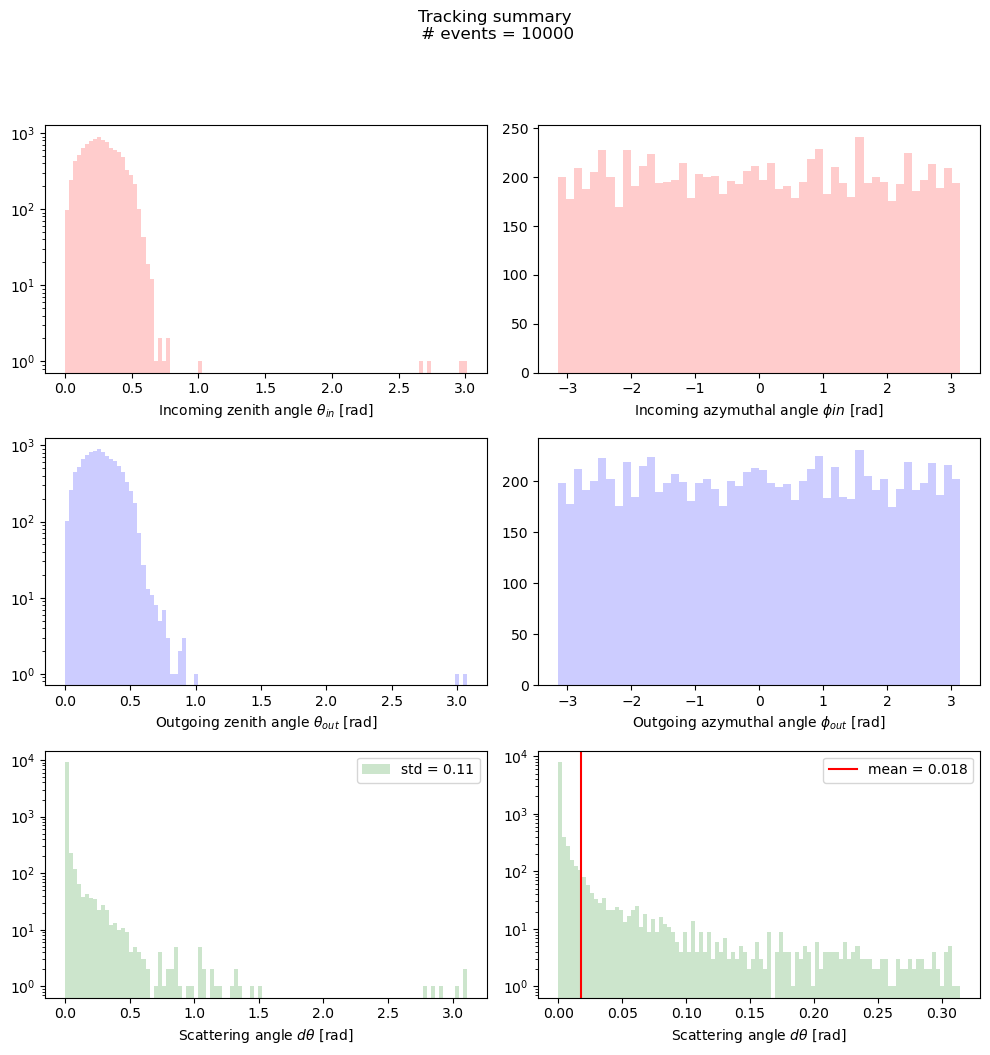

In [73]:
from tracking.tracking import Tracking
n = 10000
tracks = Tracking(hits[:,:,:n])

# plotting tracking summary
# if figname is used, the figure will be saved
tracks.plot_tracking_summary(figname="test")

 ## <center> 3 - POCA reconstruction

The `POCA` class is used both for muon path reconstruction (see slides 26-28) and scattering desnity reconstruction (see slides 30-33).

### Muon path reconstruction

In [74]:
from reconstruction.poca import POCA
poca = POCA(tracks,voi)

Scattering location computation in progress ...


Scattering location computation done


Then we can plot the POCA points (a.k.a the scattering locations) using `plot_POCA_points_multi_projection` for a 2D visualization or `plot_poca_3D_cloud` for a 3D visualization.

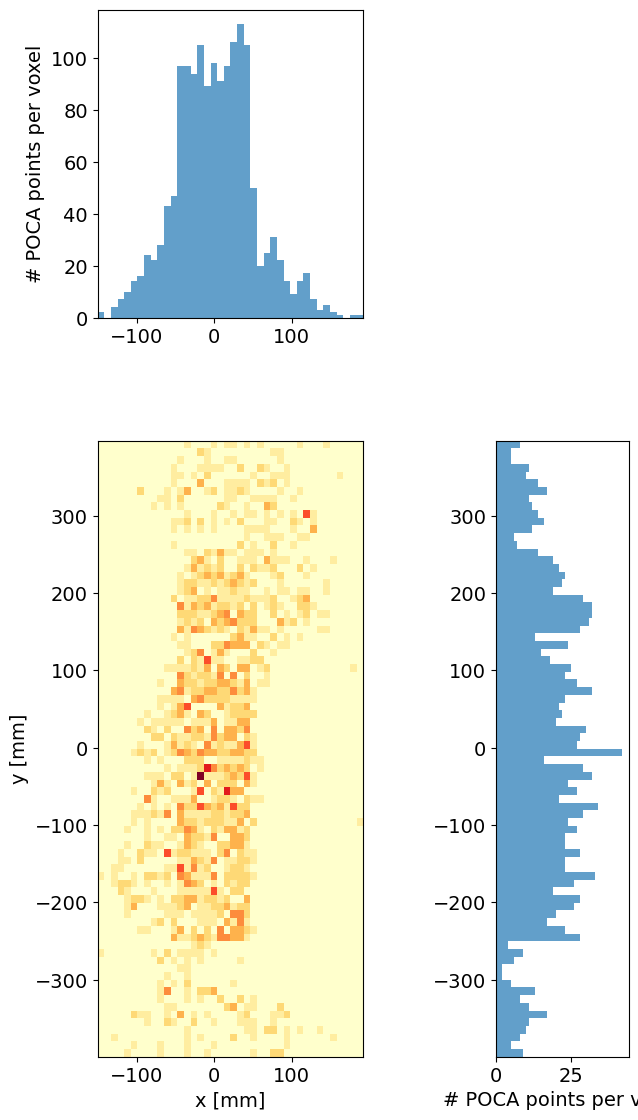

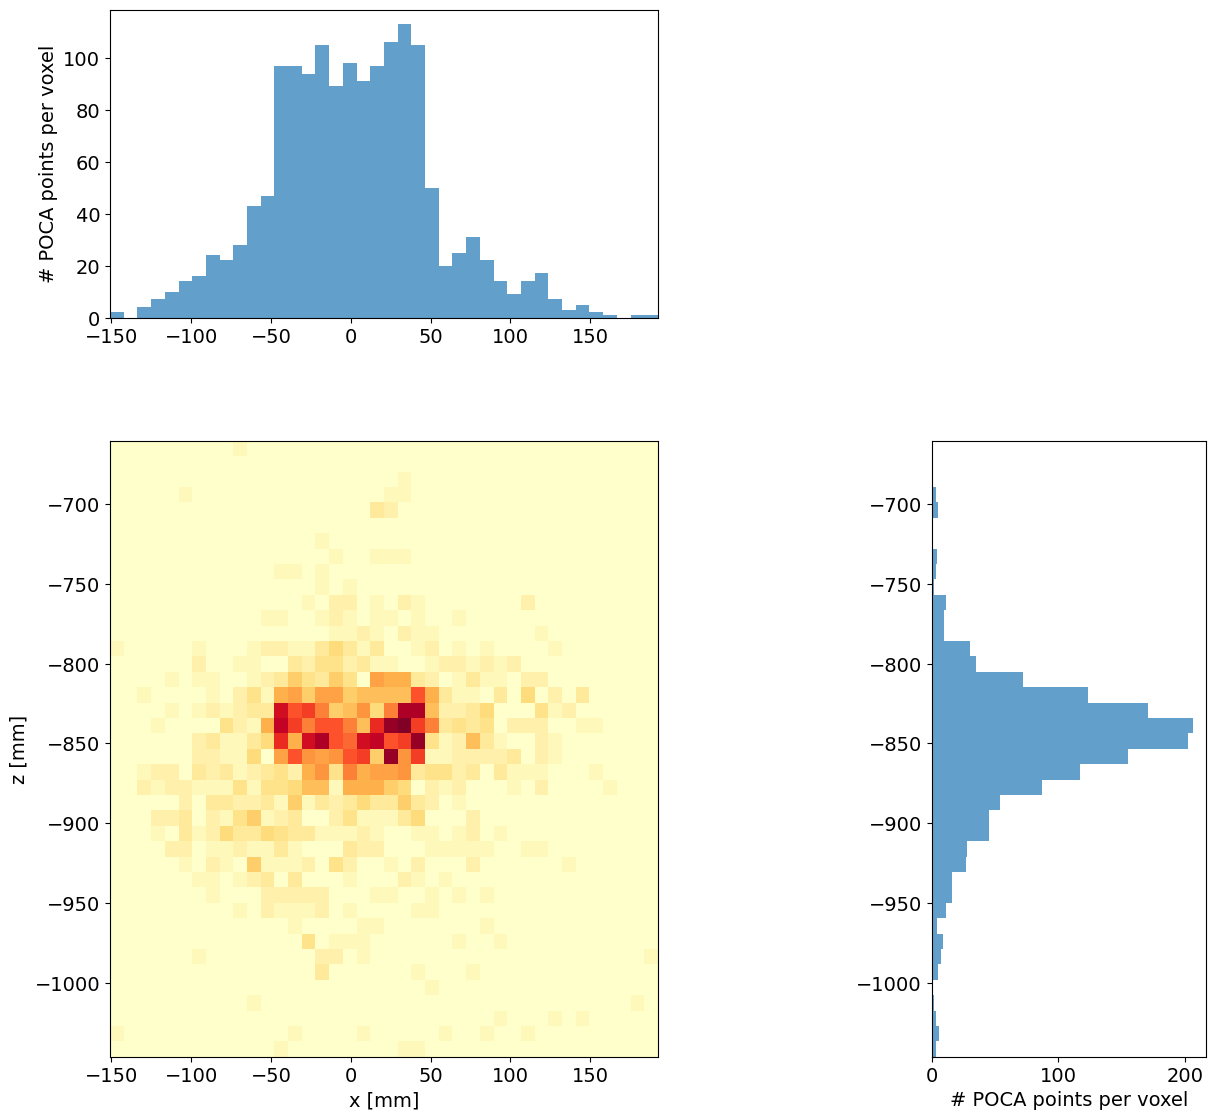

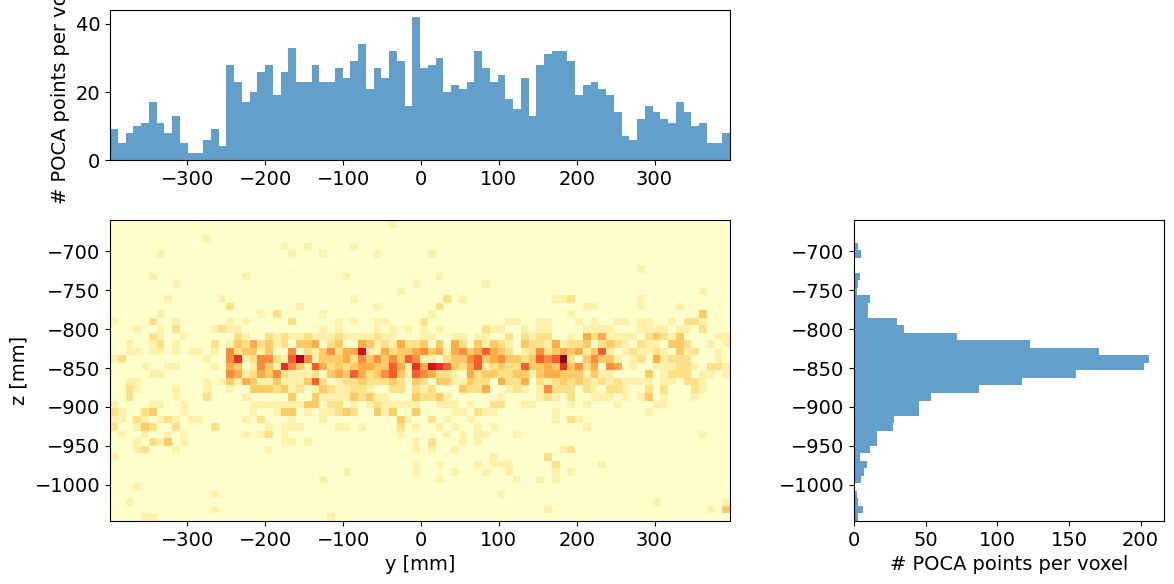

In [75]:
%matplotlib inline
from plotting.plotting import plot_POCA_points_multi_projection
plot_POCA_points_multi_projection(poca.poca_points,
                                  poca.mask_in_voi,
                                  binning_xyz=voi.n_vox_xyz,
                                  filename="TEST")

In [14]:
# select events with dtheta >3 deg
mask_high_scat = poca.mask_in_voi & (poca.tracks.dtheta*180/math.pi>1)

# plot 3d point cloud
from plotting.plotting import plot_poca_3D_cloud
%matplotlib qt
plot_poca_3D_cloud(poca, #instance of the poca class
                   mask_high_scat, # event filtering using a mask
                   alpha=.5, # set the transparancy of the points [0. - 1.
                   color=poca.tracks.dtheta[mask_high_scat]) # color proportional to the scattering angle

### Scattering density reconstruction

The scattering density reconstruction algorithm from Tutorial_3 is implemented in the POCA class. For more details about the implementation, you can have a look at the Tutorial_3 and slides 31-32.

In [16]:
# Reject events with dtheta>10 deg and dtheta<1 deg
mask = (poca.tracks.dtheta>1*math.pi/180) & (poca.tracks.dtheta<10*math.pi/180) 


from functools import partial

# run the reconstruction
scores,hit_per_voxel = poca.poca_reconstruction(score_feature=poca.tracks.dtheta, # the scores to apply to the voxels 
                                                mask=mask, # the cuts
                                                score_method = partial(np.quantile,q=.5)) # the function to extract the final score.

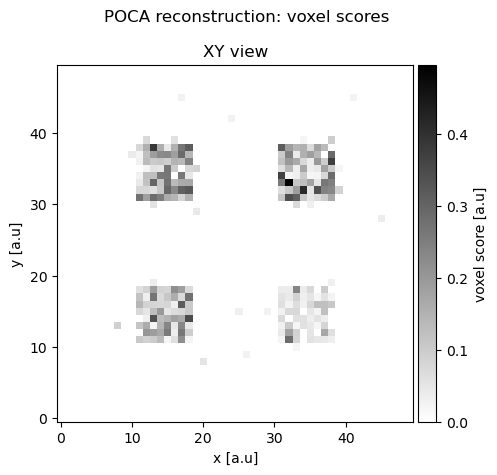

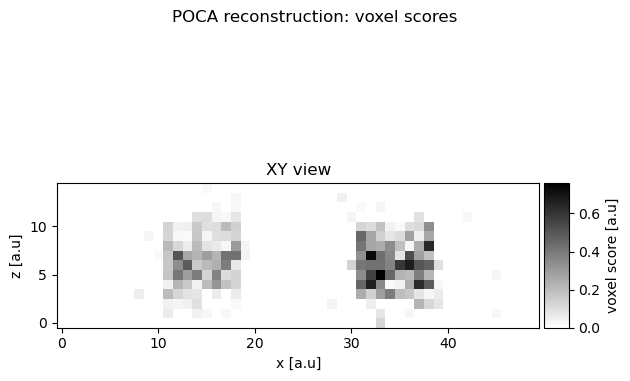

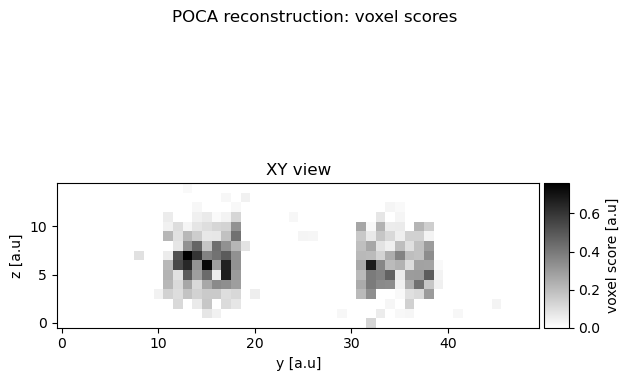

In [19]:
from plotting.plotting import plot_poca_summary
%matplotlib inline
plot_poca_summary(scores = scores,filename='test')

# Exercice: effect of spatial resolution


1 - Starting with a spatial resoultion of 2 mm and using the `np.random.normal()` function, simulate the spatial resolution of the detector by adding noise. Since we can assume that the z position of each detector is known, only the X and Y coordinate of the hits should be smeared. 

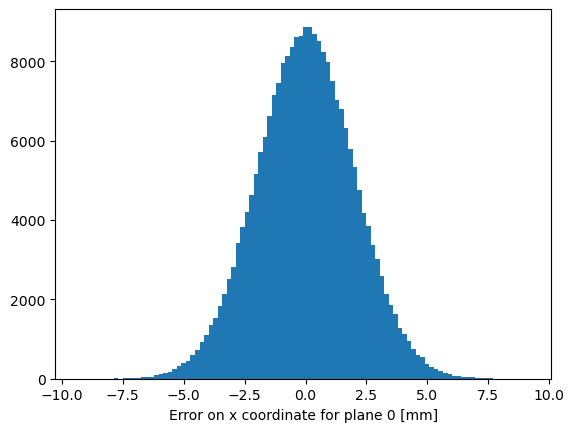

In [65]:
from utils.utils import get_hits_from_csv

#get true hits
hits = get_hits_from_csv('../data/DataCu.csv')

# get reconstructed hits
rec_hits = get_hits_from_csv('../data/DataCu.csv')

# add noise to the X and Y coordinate of each hits
rec_hits[:2]+=np.random.normal(loc=0,scale=2,size=hits[2:].shape)

# plot error on x coordinate for plane 0
fig,ax=plt.subplots()
ax.hist(rec_hits[0,0]-hits[0,0],bins=100)
ax.set_xlabel("Error on x coordinate for plane 0 [mm]")
plt.show()

2 - Running the tracking class for both the original and smeared hits, measure the angular resolution of your detector. The angular resolution is defined as the standard deviation of the error on zenith angle $\theta$ distribution, the latter being computed as $\theta_{true} - \theta_{reconstructed}$. You can plot the error on zenith angle $\theta$ distribution using the `plt.hist` function. 

`plt.hist(my_distribution, bins=100, range=(range_inf,range_sup))`

`plt.show()`

***N.B***: You might want to remove events for which tracking fails completely (e.g events for which the error on theta is above 2 radiants)

In [77]:
from tracking.tracking import Tracking
# True tracks
tracks = Tracking(hits[:,:,:50000])

Tracking in progress...


Tracking completed!


In [66]:
# Reconstructed tracks
rec_tracks = Tracking(rec_hits[:,:,:50000])

Tracking in progress...


Tracking completed!


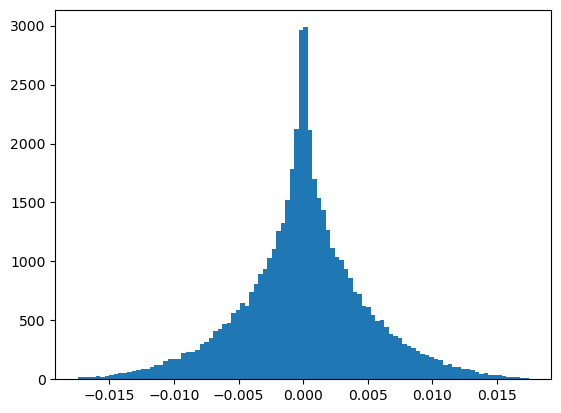

angular resolution = 0.01 rad
angular resolution = 0.78 deg


In [78]:
# Compute error on theta
theta_error = rec_tracks.theta_in - tracks.theta_in


# plot error
lim = 1*math.pi/180
plt.hist(theta_error,bins=100,range=(-lim,lim))
plt.show()

# Compute angular resolution
angular_res = np.std(theta_error[abs(theta_error)<2])
print("angular resolution = {:.2f} rad".format(angular_res))
print("angular resolution = {:.2f} deg".format(angular_res*180/math.pi))

3 - Using the POCA class, plot the poca points location for both reconstructed and true tracks.

Scattering location computation in progress ...


Scattering location computation done


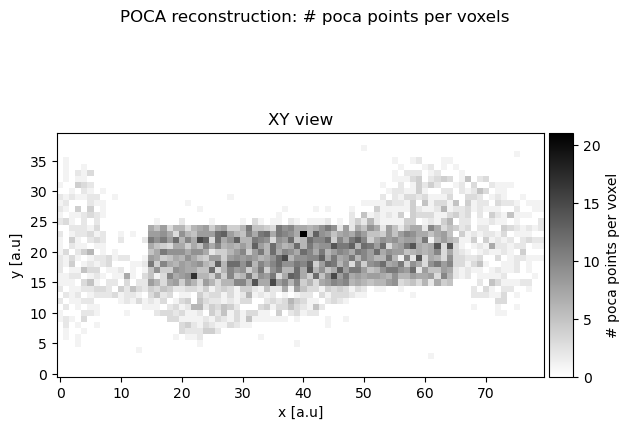

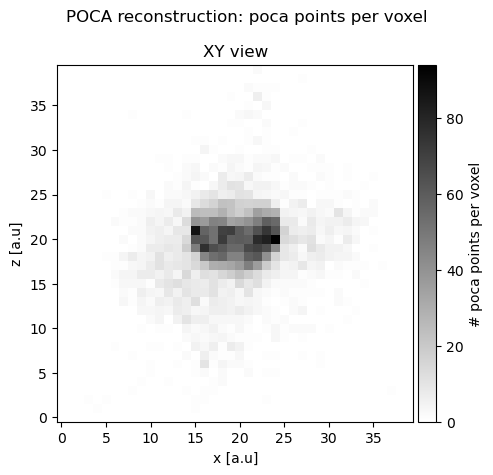

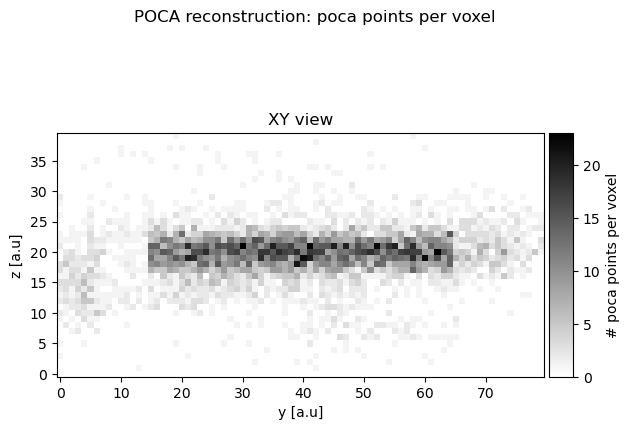

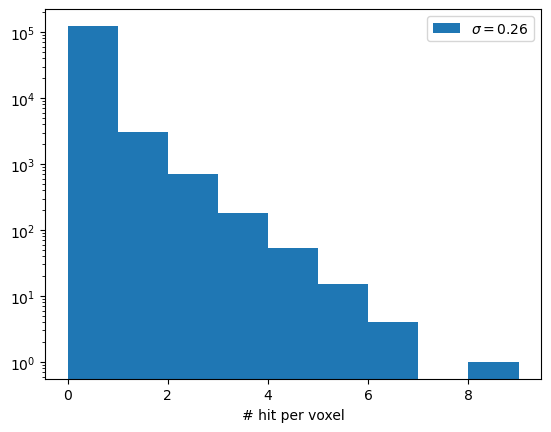

In [82]:
%matplotlib inline

# run POCA
from reconstruction.poca import POCA
poca = POCA(tracks,voi)

# run the reconstruction
mask = (poca.tracks.dtheta>.5*math.pi/180) & (poca.tracks.dtheta<10*math.pi/180) 
scores,hit_per_voxel = poca.poca_reconstruction(score_feature=poca.tracks.dtheta, # the scores to apply to the voxels 
                                                mask=mask, # the cuts
                                                score_method = partial(np.quantile,q=.5)) # the function to extract the final score.

# plot # POCA points per voxel
from plotting.plotting import plot_poca_points_summary
plot_poca_points_summary(hit_per_voxel = hit_per_voxel)

Scattering location computation in progress ...


Scattering location computation done


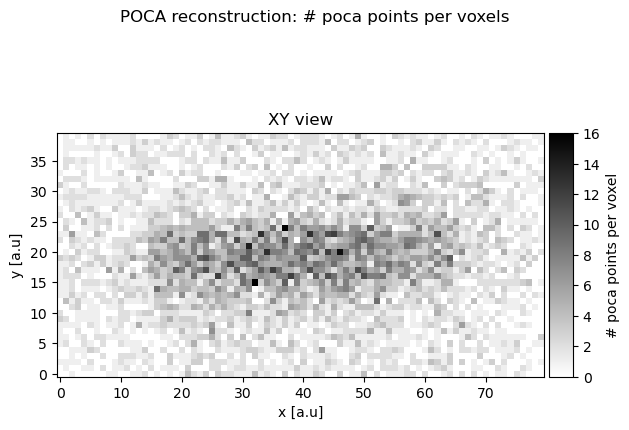

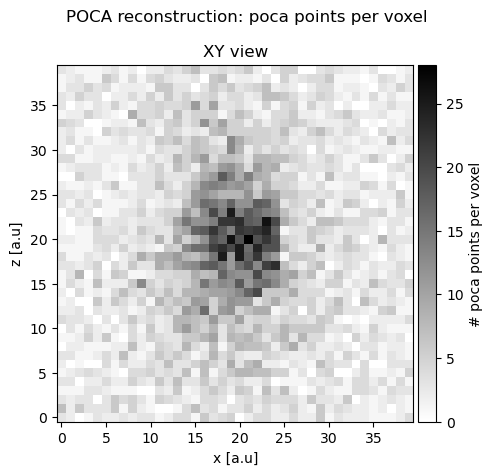

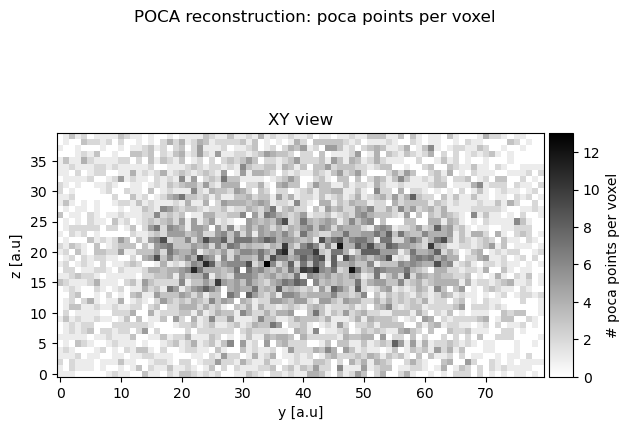

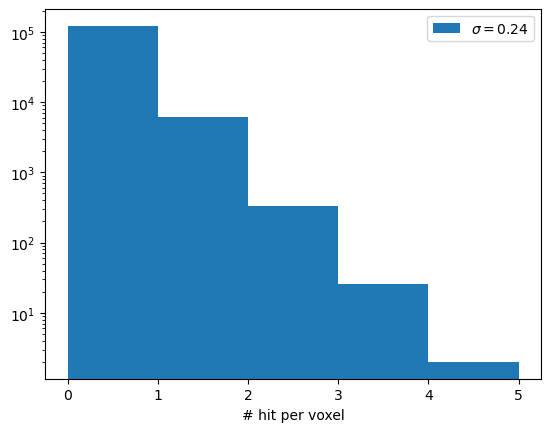

In [86]:

%matplotlib inline

# run POCA
from reconstruction.poca import POCA
poca_rec = POCA(rec_tracks,voi)

# run the reconstruction
mask = (poca_rec.tracks.dtheta>.5*math.pi/180) & (poca_rec.tracks.dtheta<10*math.pi/180) 
scores_rec,hit_per_voxel_rec = poca_rec.poca_reconstruction(score_feature=poca_rec.tracks.dtheta, # the scores to apply to the voxels 
                                                        mask=mask, # the cuts
                                                        score_method = partial(np.quantile,q=.5)) # the function to extract the final score.

# plot # POCA points per voxel
from plotting.plotting import plot_poca_points_summary
plot_poca_points_summary(hit_per_voxel = hit_per_voxel_rec)

4 - How does the spatial resolution affects the quality of the image?

6 - Other than the the spatial resoultion, what other parameter of the detector can you act on in order to minimise the angular resolution?